In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter

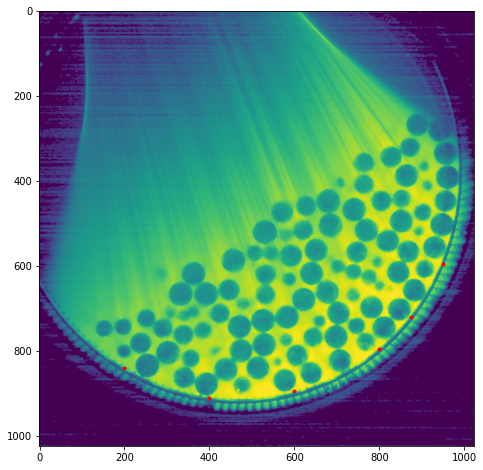

In [2]:
plt.figure(figsize=(8,8))
example_image = cv2.imread('Os4-S3 Camera000000.tif',0).astype(np.float64)
mod_image = np.log(example_image+1)
plt.imshow(mod_image)
points = np.zeros((6,2))

#points[0,:] = [0,850]
#points[1,:] = [200,970]
#points[2,:] = [400,1010]
#points[3,:] = [600,990]
#points[4,:] = [800,890]
#points[5,:] = [1000,665]

#points[0,:] = [0,710]
#points[1,:] = [200,880]
#points[2,:] = [400,945]
#points[3,:] = [600,935]
#points[4,:] = [800,840]
#points[5,:] = [1000,575]

points[0,:] = [200,840]
points[1,:] = [400,910]
points[2,:] = [600,895]
points[3,:] = [800,795]

points[4,:] = [875,720]
points[5,:] = [950,595]
plt.plot(points[:,0],points[:,1],'.',color = 'r')


In [3]:
#least squares to find a fitting circle:
def circle_error(circle_parameters):
    xc = circle_parameters[0]
    zc = circle_parameters[1]
    r = circle_parameters[2]
    return np.sum( ( (xc-points[:,0])**2 + (zc-points[:,1])**2  -r**2  )**2  )
    

In [4]:
xc = 500
zc = 500
r = 700
circle_parameters0 = [xc,zc,r]
circle_error(circle_parameters0)

#least squares
circle_parameters = least_squares(circle_error, circle_parameters0)
circle_parameters.x

array([467.54199084, 388.60519169, 524.79597658])

467.54199084057205
388.60519168600797
524.79597658237


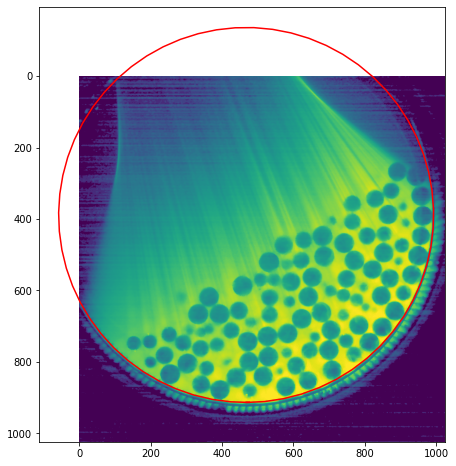

In [5]:
plt.figure(figsize=(8,8))

plt.imshow(mod_image)
#plt.ginput(n=5)
#plotting bounding circle
pi = 3.14159
xc = circle_parameters.x[0]
zc = circle_parameters.x[1]
r = circle_parameters.x[2]
dtheta = 0.1
theta = np.arange(0,2*pi+dtheta,dtheta)
x_bound = np.sin(theta)*r + xc 
z_bound = np.cos(theta)*r + zc 
plt.plot(x_bound,z_bound,'r')
print(xc)
print(zc)
print(r) 

In [6]:
#The r value for our cirlce gives a conversion between camera-space and real space
#The true diameter of the drum is 0.2m
#The radius of the drum minus the thickness of the rubber sheeting is 0.1 - 0.003 = 0.097

pixel2real = 0.097/r 
pixel2real

#The time between frame-rates is given by
deltaT = 1/300
deltaT 
print(pixel2real)

0.0001848337341145283


(84, 5)
456.7268599226064
0.18391736368260464


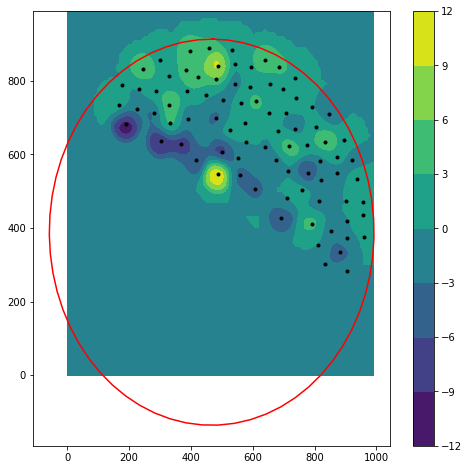

In [7]:
#importing all data points and stitching together:

#point data format is given as:

# x_coordinate | z_coordinate | radius | horizontal displacement | vertical displacement |

point_data = np.loadtxt('point_data/point_data_500.dat')
plt.figure(figsize=(8,8))



xxcg,zzcg = np.meshgrid(np.arange(0,1000,10.0),np.arange(0,1000,10.0))
rho = np.loadtxt('coarse_grained_framesc75/rho500.dat')
u = np.loadtxt('coarse_grained_framesc75/u500.dat')

print(point_data.shape )
print(np.trapz(np.trapz(rho))*10*10)

density_scaling_factor = point_data.shape[0]/np.trapz(np.trapz(rho)*10*10)
print(density_scaling_factor)
rho *= density_scaling_factor

plt.contourf(xxcg,zzcg,u)
#plt.imshow(mod_image)
plt.plot(x_bound,z_bound,'r')
plt.plot(point_data[:,0],point_data[:,1],'.',color='k')
plt.colorbar()

In [8]:
#normalising density and velocity fields:

#calculating mean velocities:
u *= 0
v = u*0
rho = rho*0
for i in range(500,3500):
    u += np.loadtxt('coarse_grained_framesc75/u'+str(i)+'.dat')
    v += np.loadtxt('coarse_grained_framesc75/v'+str(i)+'.dat')
    rho += np.loadtxt('coarse_grained_framesc75/rho'+str(i)+'.dat')

    #print(i)



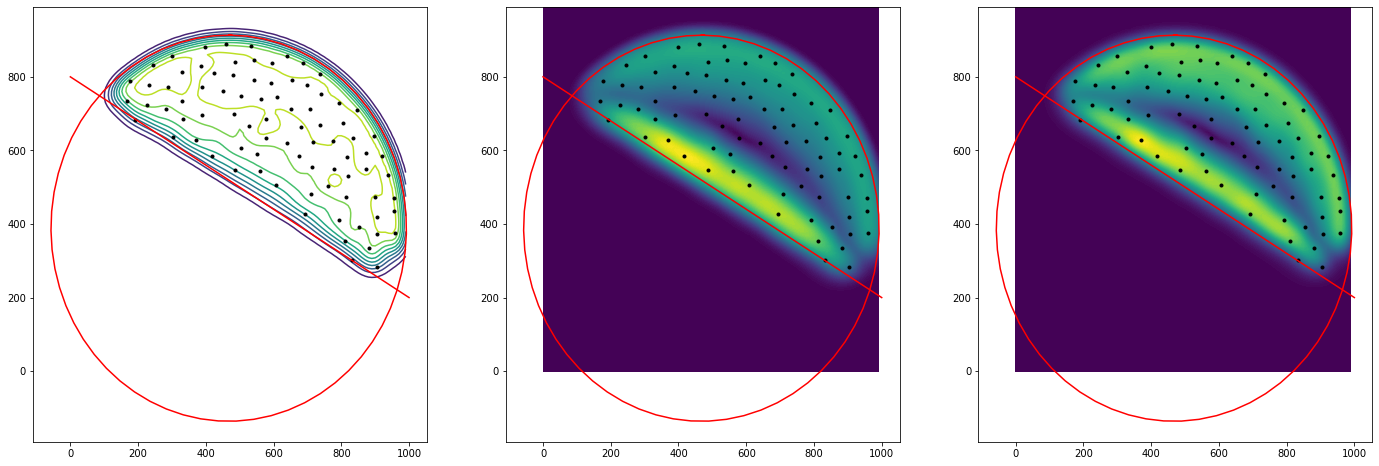

In [9]:
plt.figure(figsize=(24,8))
#converting from pixel per framerate to meters per second
u_real = u*pixel2real/3000 #meters per frame rate:
v_real = v*pixel2real/3000
frame_rate = 300 #frames per second

x = np.arange(0,1010,10)
y = 800-x*0.6



u_real *= frame_rate 
v_real *= frame_rate
plt.subplot(1, 3, 1)

contours = plt.contour(xxcg,zzcg,gaussian_filter(rho,sigma=0),levels=10)
plt.plot(x_bound,z_bound,'r')
plt.plot(point_data[:,0],point_data[:,1],'.',color='k')

plt.plot(x,y,'r')
plt.subplot(1,3,2)
contours = plt.contourf(xxcg,zzcg,np.sqrt(u_real**2 + v_real**2),levels=100)
#plt.imshow(mod_image)
plt.plot(x_bound,z_bound,'r')
plt.plot(point_data[:,0],point_data[:,1],'.',color='k')
plt.plot(x,y,'r')
plt.subplot(1,3,3)
contours = plt.contourf(xxcg,zzcg,rho*np.sqrt(u_real**2 + v_real**2),levels=100)
#plt.imshow(mod_image)
plt.plot(x_bound,z_bound,'r')
plt.plot(point_data[:,0],point_data[:,1],'.',color='k')
#plt.clabel(contours)
#plt.colorbar()
plt.plot(x,y,'r')

In [10]:
xxtrue = xxcg*pixel2real
zztrue = zzcg*pixel2real 
#building data vector:

data_vector = np.stack((xxtrue.flatten(),zztrue.flatten(),u_real.flatten(),v_real.flatten()),axis=1)

print(data_vector)
np.savetxt('RIMS_data_vector.dat',data_vector)


[[0.         0.         0.         0.        ]
 [0.00184834 0.         0.         0.        ]
 [0.00369667 0.         0.         0.        ]
 ...
 [0.17928872 0.1829854  0.         0.        ]
 [0.18113706 0.1829854  0.         0.        ]
 [0.1829854  0.1829854  0.         0.        ]]


In [11]:
print(pixel2real)

0.0001848337341145283
